    Kevin Vonk, s1706896

## $$\mbox{Logistic Regression with Gradient Descent.}$$


In [1]:
# %load ../../standard_import.txt
import copy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display, Math, Latex

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [3]:
def split_data(data):
    x0, y0 = np.hsplit(data[data[:,2] == 0, :2], 2)
    x1, y1 = np.hsplit(data[data[:,2] == 1, :2], 2)

    return x0, y0, x1, y1

In [4]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    ## the data gives the grades for two exams; 
    ## the last entry in the data is a 0 or 1: 
    ##   rejected or accepted for a certain programme
    ## make a scatter plot of the data such that 
    ## a 1 gets a black plus, the 0 a yellow (not too) large dot
    if axes == None:
        axes = plt.gca()

    x0, y0, x1, y1 = split_data(data)

    axes.plot(x0, y0, 'y.', label=label_neg)
    axes.plot(x1, y1, 'b+', label=label_pos)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend()

In [5]:
def scale_features(*elems, avg=None, std=None):
    model_given = True
    features = list(elems)

    if avg is None or std is None:
        avg, std = [np.zeros(len(elems)) for i in range(2)]
        model_given = False

    for i, elem in enumerate(elems):
        if not model_given:
            avg[i] = np.mean(elem)
            std[i] = np.std(elem)
        features[i] = (elem - avg[i]) / std[i]

    if model_given:
        return features

    return features, avg, std

### $$\mbox{Logistic regression.}$$

In [6]:
data = loaddata('../data/ex2data1.txt', ',')
data.shape

Dimensions:  (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


(100, 3)

In [7]:
## X: of the form [1 x1 x2] 
## y: 0's and 1's
features, *model = scale_features(data[:, 0], data[:, 1])
X = np.column_stack([np.ones(data.shape[0]), *features])
y = np.c_[data[:, 2]]

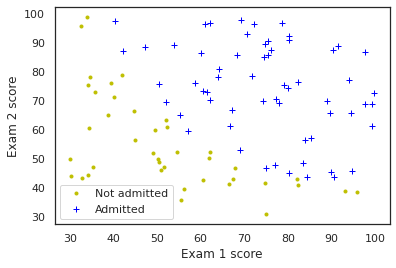

In [8]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

#### $$ \mbox{Logistic regression hypothesis:} \hspace{1cm} h_{\theta}(x) = \sigma(\theta^{T}x), ~~~ \sigma(z)=\frac{1}{1+e^{−z}} $$

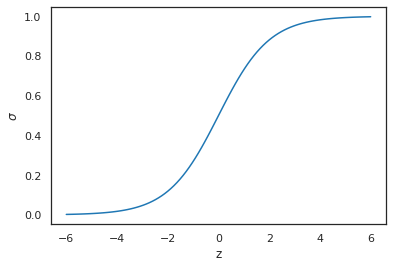

In [9]:
sigmoid = lambda z: 1/(1 + np.exp(-z))
    
## create a picture of this function on [-6, 6]
bounds = (-6, 6)
grid = 100
xxx = np.linspace(*bounds, num=grid)
yyy = sigmoid(xxx)
plt.plot(xxx, yyy, label="Sigmoid function")
plt.xlabel("z")
plt.ylabel(r"$\sigma$");


#### $$ {\mbox{Cost function:}} \hspace{1cm}     J(\theta) = -\frac{1}{m}\big(\,\ln\,(\sigma(X\theta))^Ty+\ln\,(1-\sigma(X\theta))^T(1-y)\big)$$

In [10]:
def costFunction(theta, X, y):
    m = y.size
    xt = X @ theta
    J = -1/m * (np.log(sigmoid(xt)).T @ y + np.log(1 - sigmoid(xt)).T @ (1 - y))

    if np.isnan(J):
        return np.inf

    # Due to the weird behaviour of numpy.c_, J is a 1x1 column array. Explicitly make it a float.
    return float(J)
    

#### $$ \mbox{Partial derivative:}\hspace{1cm}\frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m} X^T(\sigma(X\theta)-y)$$

Both the vector theta and the gradient should for this problem be (3,1)

In [11]:
def gradient(theta, X, y):
    m = y.size
    grad = 1/m * X.T @ (sigmoid(X @ theta) - y)
    return grad

In [12]:
## checking the shapes and values
initial_theta = np.c_[np.zeros(X.shape[1])] 
print('Shape theta: \n', initial_theta.shape)
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Initial cost: \n', cost) 
print('Grad: \n', grad.T)
print('Shape grad: \n', grad.shape)

Shape theta: 
 (3, 1)
Initial cost: 
 0.693147180559945
Grad: 
 [[-0.1        -0.28122914 -0.25098615]]
Shape grad: 
 (3, 1)


#### $$\mbox{Optimize cost function.}$$

In GradientDescent (below) you have to play with the learning parameter alpha and the number of interations: you cannot tell what good values are. 

Keep the values for costfunction at intermediate steps in order to view the convergence.

If this num_iters must be chosen very large (did the process converge?) you should write an extra loop within the loop


In [13]:
def gradient_runner(X, y, theta, alpha=0.001, MAX_ITER=10000, TOL=1E-4):
    done = lambda prev, cur: np.abs(cur - prev) <= TOL
    iter = 0

    prevJ = 999
    J = 995

    while not done(prevJ, J) and iter <= MAX_ITER:
        prevJ = J
        theta -= alpha * gradient(theta, X, y)
        J = costFunction(theta, X, y)

        yield iter, theta, J
        iter += 1


def gradientDescent(*args, numiters = 5500, to_store=100, **kwargs):
    Jh = []
    for i, theta, J in gradient_runner(*args, MAX_ITER=numiters, **kwargs):
        if i % to_store == 0:
            Jh.append(J)

    return theta, np.array(Jh)
    

Initial cost:  0.693147180559945
Final cost:  0.2042391664100851
Values of theta:  [1.56243475] [3.66096269] [3.4041362]


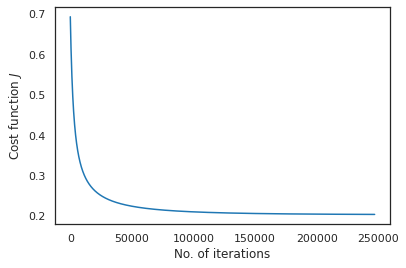

In [14]:
theta = copy.deepcopy(initial_theta)
to_store = 100

print('Initial cost: ', costFunction(theta, X, y))
theta, Jh = gradientDescent(X, y, theta, alpha=0.001, numiters=1E6, to_store=to_store, TOL=1E-8)
print('Final cost: ', costFunction(theta, X, y))
print('Values of theta: ', *theta)
## plot the history of the cost function
## put sensible text on axis
plt.plot(range(0, Jh.size * to_store, to_store), Jh)
plt.xlabel("No. of iterations")
plt.ylabel(r"Cost function $J$");

How much from the whole data set using the optimized theta values from above has the correct classification?

In [15]:
def predict(theta, X, threshold = 0.5):
    hypo = sigmoid(X @ theta)
    count = len(hypo[hypo > threshold])

    return count

p = predict(theta, X) 
print(f"Algorithm predicts {p} passes, actual data gives {len(data[data[:, 2] == 1, 2])}")

Algorithm predicts 61 passes, actual data gives 60


In [16]:
# Student with Exam 1 score 45 and Exam 2 score 85: will he pass?
test_suite = ((30, 30), (75, 50), (45, 85))
for test in test_suite:
    test_features = [(val - model[0][i]) / model[1][i] for i, val in enumerate(test)]
    p = predict(theta, [1, *test_features])
    print(f"A student with score 1 = {test[0]} and score 2 = {test[1]} will {'pass' if p == 1 else 'fail'}.")

A student with score 1 = 30 and score 2 = 30 will fail.
A student with score 1 = 75 and score 2 = 50 will pass.
A student with score 1 = 45 and score 2 = 85 will pass.


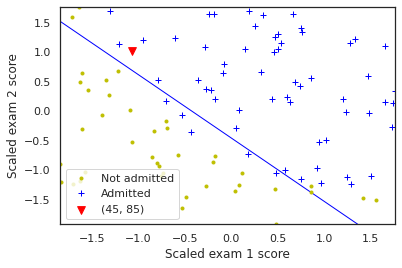

In [17]:
scaled_data = scale_features(data[:, 0], data[:, 1], avg=model[0], std=model[1])

plt.scatter(*test_features, s=60, c='r', marker='v', label='(45, 85)')
plotData(np.column_stack([*scaled_data, data[:, 2]]), 'Scaled exam 1 score', 'Scaled exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(theta))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');